(3000, 144, 216, 3)
3000
(1000, 144, 216, 3)
진행중
진행중2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 216, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 108, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxP

Epoch 13/100
150/150 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8458
Epoch 00013: val_loss did not improve from 0.62651
150/150 [==============================] - 16s 108ms/step - loss: 0.3616 - accuracy: 0.8458 - val_loss: 0.6757 - val_accuracy: 0.7233
Epoch 14/100
150/150 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8700
Epoch 00014: val_loss did not improve from 0.62651
150/150 [==============================] - 16s 106ms/step - loss: 0.3310 - accuracy: 0.8700 - val_loss: 0.7489 - val_accuracy: 0.7233
Epoch 15/100
150/150 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8746
Epoch 00015: val_loss did not improve from 0.62651
150/150 [==============================] - 16s 106ms/step - loss: 0.3074 - accuracy: 0.8746 - val_loss: 0.8084 - val_accuracy: 0.7417
Epoch 16/100
150/150 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8783
Epoch 00016: val_loss did not improve from 0.62651
32

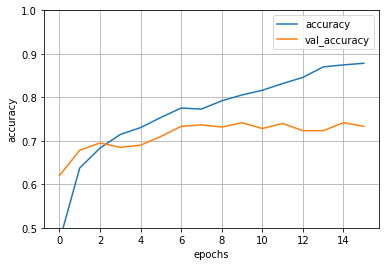

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       240
           1       0.69      0.65      0.67       265
           2       0.88      0.83      0.85       235
           3       0.87      0.88      0.88       260

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

[[176  34   2  28]
 [ 66 172  23   4]
 [  5  35 194   1]
 [ 23   7   2 228]]


In [2]:
from PIL import Image
import tensorflow as tf
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
import os, glob, numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline 



# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#       print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     print(e)

X_train, X_test, y_train, y_test = np.load("C:/Users/PC/표/sleep_file/새 폴더/EDF_Data/eeg+eeg_fft+eog+eog_fft.npy",allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
# categories =["1_emg", "2_emg","3_emg","R_emg"]
categories =["1+1","2+2", "3+3","R+R"]
nb_classes = len(categories)

#일반화
print('진행중')
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
print('진행중2')
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"],
                      cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = "C:/Users/PC/표/sleep_file/새 폴더/EDF_Data"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/eeg'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


model.summary()
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stopping])
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


model.save('eeg+eeg_fft+eog+eog_fft')

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()

In [3]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [6]:
accuracy.pop()
val_accuracy.pop()

0.7333333492279053

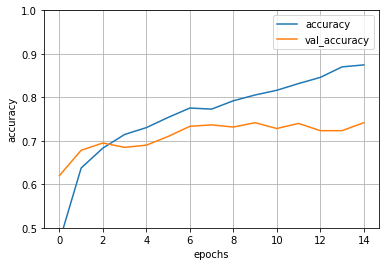

In [7]:
plt.plot(accuracy)
plt.plot(val_accuracy)
# plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.grid()
plt.show()